In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Define the architecture of the neural network
input_size = 28 * 28  # Flattened image size
hidden_sizes = [500, 250, 100]
output_size = 10  # Number of classes
num_epochs = 15


# Define the learning rate and batch size
learning_rate = 0.01
batch_size = 64

# Load the MNIST dataset and prepare it
# Load data
# Data preprocessing and loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./', train=False, download=True, transform=transform)

validation_size = 5000
train_size = len(dataset) - validation_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


In [3]:
# Initialize weights using Glorot initialization
def initialize_weights(size):
    M = np.sqrt(6.0 / (size[0] + size[1]))
    return np.random.uniform(-M, M, size)

# Create weight and bias parameters for each layer
weights = [initialize_weights((input_size, hidden_sizes[0]))]
biases = [np.zeros((1, hidden_sizes[0]))]
for i in range(1, len(hidden_sizes)):
    weights.append(initialize_weights((hidden_sizes[i-1], hidden_sizes[i])))
    biases.append(np.zeros((1, hidden_sizes[i])))
weights.append(initialize_weights((hidden_sizes[-1], output_size)))
biases.append(np.zeros((1, output_size)))

In [4]:
# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define the softmax activation function
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Define the cross-entropy loss function
def cross_entropy_loss(y, y_hat):
    return -np.mean(y * np.log(y_hat + 1e-9))

In [5]:
# Training loop
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        # Flatten the images
        images = images.view(images.shape[0], -1)

        # Forward pass
        input_layer = images
        h1 = relu(np.dot(input_layer, weights[0]) + biases[0])
        h2 = relu(np.dot(h1, weights[1]) + biases[1])
        h3 = relu(np.dot(h2, weights[2]) + biases[2])
        output = softmax(np.dot(h3, weights[3]) + biases[3])
        # Convert labels to one-hot vectors
        y_one_hot = np.zeros((labels.size()[0], output_size))
        y_one_hot[np.arange(labels.size()[0]), labels] = 1

        # Compute the loss
        loss = cross_entropy_loss(y_one_hot, output)
        total_loss += loss

        # Backpropagation
        grad_output = (output - y_one_hot) / batch_size
        grad_h3 = np.dot(grad_output, weights[3].T)
        grad_h3[h3 <= 0] = 0
        grad_h2 = np.dot(grad_h3, weights[2].T)
        grad_h2[h2 <= 0] = 0
        grad_h1 = np.dot(grad_h2, weights[1].T)
        grad_h1[h1 <= 0] = 0

        # Update weights and biases
        weights[3] -= learning_rate * np.dot(h3.T, grad_output)
        biases[3] -= learning_rate * grad_output.sum(axis=0)
        weights[2] -= learning_rate * np.dot(h2.T, grad_h3)
        biases[2] -= learning_rate * grad_h3.sum(axis=0)
        weights[1] -= learning_rate * np.dot(h1.T, grad_h2)
        biases[1] -= learning_rate * grad_h2.sum(axis=0)
        weights[0] -= learning_rate * np.dot(input_layer.T, grad_h1)
        biases[0] -= learning_rate * grad_h1.sum(axis=0)

    train_losses.append(total_loss / len(train_loader))

    # Evaluate the model on the test set
    validation_loss = 0
    for images, labels in validation_loader:
        images = images.view(images.shape[0], -1)
        input_layer = images
        h1 = relu(np.dot(input_layer, weights[0]) + biases[0])
        h2 = relu(np.dot(h1, weights[1]) + biases[1])
        h3 = relu(np.dot(h2, weights[2]) + biases[2])
        output = softmax(np.dot(h3, weights[3]) + biases[3])
        y_one_hot = np.zeros((labels.size()[0], output_size))
        y_one_hot[np.arange(labels.size()[0]), labels] = 1
        loss = cross_entropy_loss(y_one_hot, output)
        validation_loss += loss
    validation_losses.append(validation_loss / len(validation_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}')

Epoch [1/15], Train Loss: 0.0548, Validation Loss: 0.0302
Epoch [2/15], Train Loss: 0.0277, Validation Loss: 0.0234
Epoch [3/15], Train Loss: 0.0223, Validation Loss: 0.0190
Epoch [4/15], Train Loss: 0.0187, Validation Loss: 0.0165
Epoch [5/15], Train Loss: 0.0162, Validation Loss: 0.0168
Epoch [6/15], Train Loss: 0.0142, Validation Loss: 0.0134
Epoch [7/15], Train Loss: 0.0127, Validation Loss: 0.0122
Epoch [8/15], Train Loss: 0.0113, Validation Loss: 0.0116
Epoch [9/15], Train Loss: 0.0103, Validation Loss: 0.0108
Epoch [10/15], Train Loss: 0.0094, Validation Loss: 0.0101
Epoch [11/15], Train Loss: 0.0086, Validation Loss: 0.0101
Epoch [12/15], Train Loss: 0.0079, Validation Loss: 0.0096
Epoch [13/15], Train Loss: 0.0073, Validation Loss: 0.0090
Epoch [14/15], Train Loss: 0.0067, Validation Loss: 0.0082
Epoch [15/15], Train Loss: 0.0063, Validation Loss: 0.0089


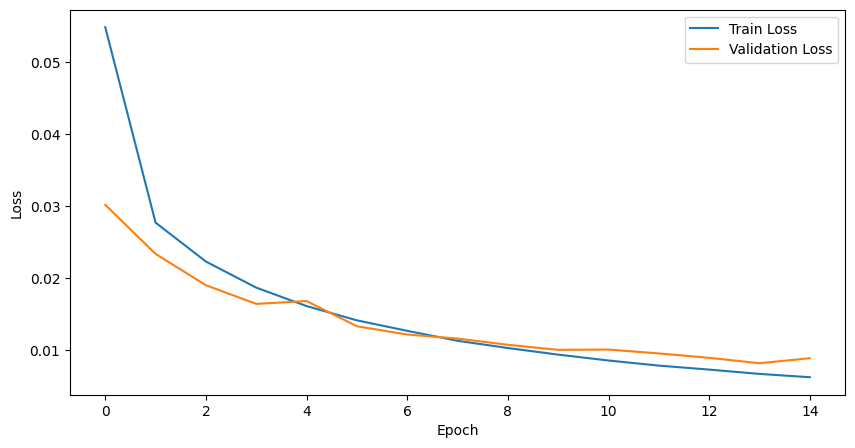

[0.030191687010989135, 0.023381236700075345, 0.019040369427454216, 0.01645121281963861, 0.01684721512231834, 0.013352850023545096, 0.012206169884424823, 0.011648597659952539, 0.010779746765508023, 0.01008185865211314, 0.010119903455333512, 0.00958296666837289, 0.008974783568564852, 0.008226707223114112, 0.00892011582511033]


In [6]:
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(validation_losses)

Confusion Matrix (Test Set):[[ 969    0    0    0    0    2    2    2    3    2]
 [   0 1121    4    0    0    1    4    1    4    0]
 [   6    2 1001    0    3    0    2    8    9    1]
 [   0    0   11  961    1   14    0    7   14    2]
 [   1    0    4    0  969    0    3    2    0    3]
 [   6    1    0    3    6  858    6    1    8    3]
 [   6    3    0    0    8    6  929    0    6    0]
 [   1    9   10    0    5    0    0  989    2   12]
 [   3    0    2    2    7    2    3    4  947    4]
 [   5    4    1    3   29    0    0    6    5  956]]
Confusion Matrix:


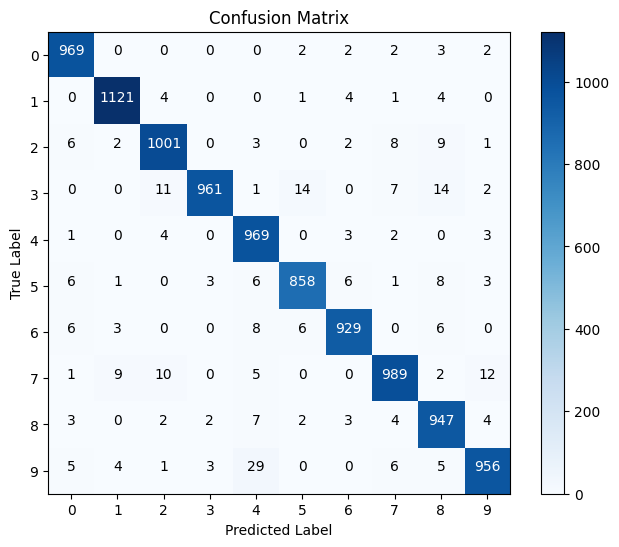

Accuracy (Test Set):97.0


In [7]:

true_test_labels = []
pred_test_labels = []
test_losses = []

# Evaluate the model on the test set
test_loss = 0
for images, labels in test_loader:
    images = images.view(images.shape[0], -1)
    input_layer = images
    h1 = relu(np.dot(input_layer, weights[0]) + biases[0])
    h2 = relu(np.dot(h1, weights[1]) + biases[1])
    h3 = relu(np.dot(h2, weights[2]) + biases[2])
    output = softmax(np.dot(h3, weights[3]) + biases[3])
    y_one_hot = np.zeros((labels.size()[0], output_size))
    y_one_hot[np.arange(labels.size()[0]), labels] = 1
    # Store true and predicted labels for test set
    true_test_labels.extend(labels)
    pred_test_labels.extend(np.argmax(output, axis=1))
    loss = cross_entropy_loss(y_one_hot, output)
    test_loss += loss
test_losses.append(test_loss / len(test_loader))

# Generate and display confusion matrix
confusion = confusion_matrix(true_test_labels, pred_test_labels)

print(f"Confusion Matrix (Test Set):{confusion}")
print('Confusion Matrix:')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

for i in range(10):
    for j in range(10):
        plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy (Test Set):{100*accuracy_score(true_test_labels, pred_test_labels)}")

Epoch [1/5], Loss: 0.2549623844414195
Epoch [2/5], Loss: 0.36724012335644496
Epoch [3/5], Loss: 0.5022200517560736
Epoch [4/5], Loss: 0.6215218570130536
Epoch [5/5], Loss: 0.7370261980527187
Accuracy on the test set: 94.40%
Confusion Matrix:
[[ 951    0    5    2    1   10    4    5    2    0]
 [   0 1111    6    4    0    2    1    1    9    1]
 [  11    2  985    2    3    3    3    9   13    1]
 [   1    0   34  939    0   13    0   12    8    3]
 [   3    0    5    0  905    1   11    1   18   38]
 [   4    0    3   14    0  849    4    4    8    6]
 [   7    2    4    0    1   25  910    1    7    1]
 [   1    6   22    2    2    0    0  973    6   16]
 [   2    0    6   46    4   22    5    4  882    3]
 [   7    5    1   12   11   10    1   10   17  935]]


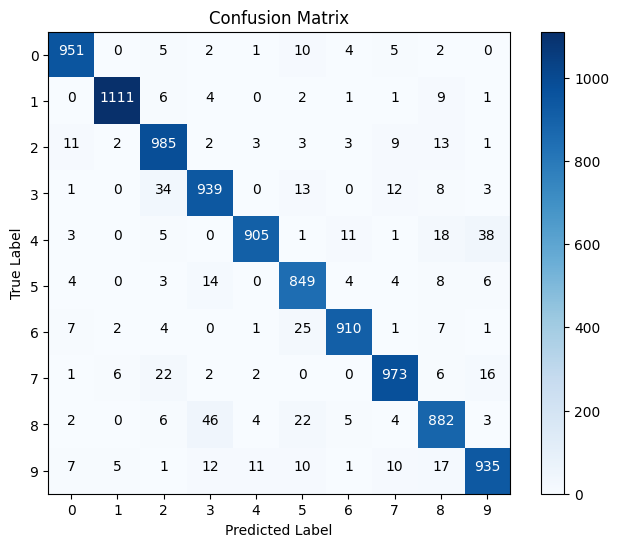

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize the model, loss function, and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
num_epochs = 5
train_losses = []
train_loss = 0
validation_loss = 0
validation_losses = []
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
    train_losses.append(train_loss/len(train_loader))

    # Evaluate the model on the test set
    for images, labels in validation_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
    validation_losses.append(validation_loss / len(validation_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {sum(validation_losses)/ len(validation_losses)}')


# Evaluation and generating confusion matrix
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

for i in range(10):
    for j in range(10):
        plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Epoch [1/5], Loss: 0.47214940162592156
Epoch [1/5], Loss: 0.35617057333075547
Epoch [2/5], Loss: 0.637331977315507
Epoch [2/5], Loss: 0.5330795214711865
Epoch [3/5], Loss: 0.7952601508879962
Epoch [3/5], Loss: 0.6865082350304107
Epoch [4/5], Loss: 0.9498426892957108
Epoch [4/5], Loss: 0.8308864765906636
Epoch [5/5], Loss: 1.1005637591592101
Epoch [5/5], Loss: 0.9819759495650666
Accuracy on the test set: 90.29%
Confusion Matrix:
[[ 943    0    4    0    2    3   18    5    0    5]
 [   0 1116    6    0    0    2    0    7    4    0]
 [   4    2  986    0    4    2    6   25    1    2]
 [   0   13   44  861    1   35    1   39   10    6]
 [   1    2    7    0  732    0   44    8    4  184]
 [  10    7    8   11    1  793   23   26    3   10]
 [  10    3   23    1    0   10  909    1    1    0]
 [   2    3   14    0    1    0    3 1000    0    5]
 [  15    3   36   22    5   16   25   43  783   26]
 [   7    8    1    3   13    3    1   60    7  906]]


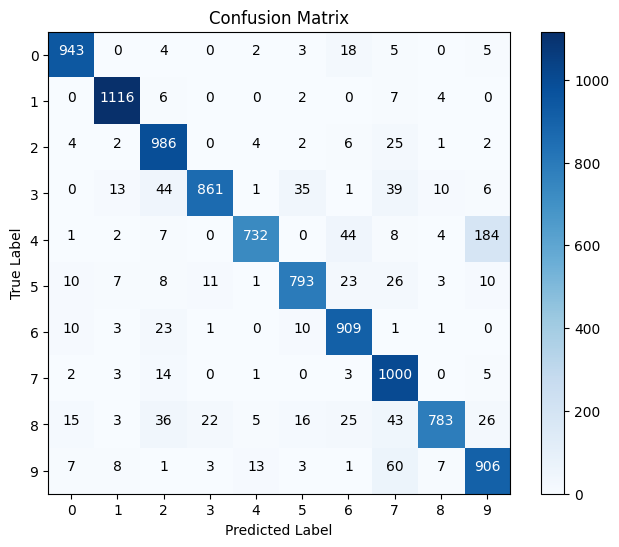

In [17]:
# Define a neural network model
class Net(nn.Module):
    def __init__(self, l2_reg):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

        # L2 regularization
        self.l2_reg = l2_reg

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize the neural network with L2 regularization
l2_reg = 0.001  # Adjust this value as needed
model = Net(l2_reg)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

# Training the model
num_epochs = 5
train_losses = []
train_loss = 0
validation_loss = 0
validation_losses = []
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
    train_losses.append(train_loss/len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {sum(train_losses)/ len(train_losses)}')


    # Evaluate the model on the test set
    for images, labels in validation_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        validation_loss += loss.item()
    validation_losses.append(validation_loss / len(validation_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {sum(validation_losses)/ len(validation_losses)}')


# Evaluation and generating confusion matrix
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
print('Confusion Matrix:')
print(confusion)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

for i in range(10):
    for j in range(10):
        plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()